In [1]:
from Modular_code.utils import *
from Modular_code.clr import OneCycle
from Modular_code.radam import RAdam
from Modular_code.opts import *

In [2]:
import pandas as pd
train_label = pd.read_csv(train_label_path)
valid_label = pd.read_csv(valid_label_path)
test_label = pd.read_csv(test_label_path)

In [3]:
train_id,train_classes = create_label(train_label,'./DataSet/Train') 
test_id,test_classes = create_label(test_label,'./DataSet/Test')
valid_id,valid_classes = create_label(valid_label,'./DataSet/Validation') 

In [4]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
class video_dataset(Dataset):
    def __init__(self,id,label,sequence_length = 60,transform = None):
        self.id =id
        self.engagement = label
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.id)-self.count
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        a = int(300/self.count)
        hp = np.random.randint(0,2)
        label = self.engagement[idx]
        for frame in frame_extract(video_path):
            if(hp == 1):
                frame = cv2.flip(frame,1)
            frames.append(self.transform(frame))
        frames = torch.stack(frames)
        frames = frames[::a,:,:,:]
        frames = frames[:self.count]
        frames = frames.reshape(self.count,3,im_size,im_size)
        return frames,label

In [5]:
import math
train_id0 = []
train_classes0 = []
for i in range(len(train_id)):
    if(train_classes[i] != 0):
        continue
    train_id0.append(train_id[i])
train_id1 = []
train_classes1 = []
for i in range(len(train_id)):
    if(train_classes[i] != 1):
        continue
    train_id1.append(train_id[i])
train_id2 = []
train_classes2 = []
for i in range(len(train_id)):
    if(train_classes[i] != 2):
        continue
    train_id2.append(train_id[i])
train_id3 = []
train_classes3 = []
for i in range(len(train_id)):
    if(train_classes[i] != 3):
        continue
    train_id3.append(train_id[i])
id1 = []
a = []
for i in range(math.ceil(len(train_id1)/34)*34):
    if(i>=213):
        i = i-213
    a.append(train_id1[i])
    if(len(a) == 34):
        id1.append(a)
id1 = id1[0]
id2 = []
a = []
for i in range(math.ceil(len(train_id2)/34)*34):
    if(i>=2615):
        i = i-2615
    a.append(train_id2[i])
    if(len(a) == 34):
        id2.append(a)
id2 = id2[0]
id3 = []
a = []
for i in range(math.ceil(len(train_id3)/34)*34):
    if(i>=2493):
        i = i-2493
    a.append(train_id3[i])
    if(len(a) == 34):
        id3.append(a)
id3 = id3[0]
train_id_new = []
train_classes_new = []
ind1 = 0
ind2 = 0
ind3 = 0
import numpy as np
for i in range(76):
    a = []
    b = []
    a += train_id0
    b += np.zeros((34),dtype = int).tolist()
    
    a += id1[ind1*34:ind1*34+34]
    ind1 = ind1+1
    if(ind1*34 == len(id1)):
        ind1 = 0
    b += np.ones((34),dtype = int).tolist()
    a += id2[ind2*34:ind2*34+34]
    ind2 = ind2+1
    if(ind2*34 == len(id2)):
        ind2 = 0
    b += (np.ones((34),dtype = int)*2).tolist()
    a += id3[ind3*34:ind3*34+34]
    ind3 = ind3+1
    if(ind3*34 == len(id3)):
        ind3 = 0
    b += (np.ones((34),dtype = int)*3).tolist()
    train_id_new +=a
    train_classes_new +=b

In [6]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2,saturation = 0.2),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_id_new,train_classes_new,sequence_length = 150,transform = train_transforms)
val_data = video_dataset(valid_id,valid_classes,sequence_length = 150,transform = test_transforms)
test_data = video_dataset(test_id,test_classes,sequence_length = 150,transform = test_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


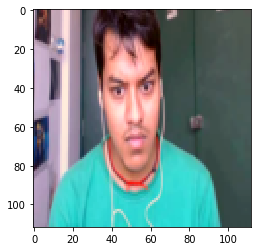

In [7]:
import cv2
import random
image,_ = train_data[3900]
im_plot(image[10,:,:,:])

In [9]:
from efficientnet_pytorch import EfficientNet
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish(nn.Module):
    @staticmethod
    def forward(x):
        return SwishImplementation.apply(x)

In [28]:
#!git clone https://github.com/ndrplz/ConvLSTM_pytorch
size = 3
from ConvLSTM_pytorch.convlstm import ConvLSTM
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        model1 = EfficientNet.from_pretrained('efficientnet-b0').cuda() 
        for param in model1.parameters():
            param.requires_grad = False
        self.model1 = model1
        c1 = ConvLSTM(  input_size=(size,size),
                             input_dim= 1280,
                             hidden_dim=[128,512],
                             kernel_size=(3,3),
                             num_layers=2,
                             batch_first = True,
                             bias=False,
                             return_all_layers = False)

        self.c1 = c1
        self.f1 = nn.Linear(512*size*size,1024)
        self.relu = Swish()
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,4)
        self.dp = nn.Dropout(0.2)
    def forward(self, input):
        x = self.model1.extract_features(input)
        x = x.view(-1,150,1280,size,size).detach()
        x = self.c1(x)
        #x = torch.mean(x[0][0],dim = 1)
        x = x[0][0][:,-1,:,:,:]
        x = x.view(-1,512*size*size).detach()
        x = self.dp(self.relu(self.f1(x)))
        x = self.dp(self.relu(self.fc2(x)))
        x = self.dp(self.fc3(x))
        return x
model = Model().to('cuda')
model = nn.DataParallel(model)

Loaded pretrained weights for efficientnet-b0


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [25]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
class_weights = torch.from_numpy(np.asarray([0.01,0.1,0.46,0.44])).type(torch.FloatTensor).cuda()
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer, epoch_logger, batch_logger, batch_size , onecyc , writer , result_path):
    print('Training Epoch {}'.format(epoch))
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    start_time = time.time()
    end_time = time.time()
    for i, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if(inputs.size(0)<batch_size):
            continue
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        with torch.no_grad():
            inputs = inputs.reshape(-1,3,im_size,im_size)
        outputs = model(inputs)
#        outputs = torch.mul(outputs,class_weights)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        lr,_ = onecyc.calc()
        update_lr(optimizer, lr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del inputs,targets,outputs
        batch_time.update(time.time() - end_time)
        end_time = time.time()

        batch_logger.log({
            'epoch': epoch,
            'batch': i + 1,
            'iter': (epoch - 1) * len(data_loader) + (i + 1),
            'loss': losses.val,
            'acc': accuracies.val,
            'lr': optimizer.param_groups[0]['lr']
        })
        writer.add_scalar('data/acc', accuracies.val, (epoch - 1) * len(data_loader) + (i + 1))
        writer.add_scalar('data/loss', losses.val, (epoch - 1) * len(data_loader) + (i + 1))        
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg
                    )
                )
    print('\nEpoch time {} mins'.format((end_time-start_time)/60))
    epoch_logger.log({
        'epoch': epoch,
        'loss': losses.avg,
        'acc': accuracies.avg,
        'lr': optimizer.param_groups[0]['lr']
    })
    writer.add_scalar('data/acc_epoch', accuracies.avg, epoch)
    writer.add_scalar('data/loss_epoch', losses.avg, epoch)        
        
    save_file_path = os.path.join(result_path,'save.pth')
    states = {
        'state_dict': model.state_dict()
    }
    torch.save(states, save_file_path)

def test(epoch,model, data_loader ,criterion, batch_size, result_path,best_acc = 0 , logger = None ):
    print('Testing')
    if(epoch == 1):
        best_acc = 0
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    for i, (inputs, targets) in enumerate(data_loader):
        if(inputs.size(0)<batch_size):
            continue
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        with torch.no_grad():
            inputs = inputs.reshape(-1,3,im_size,im_size)
        targets = Variable(targets)
        outputs = model(inputs)
#        outputs = torch.mul(outputs,class_weights)
        _,p = torch.max(outputs,1)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        true += targets.detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                    )
                )
    if(logger):
        logger.log({'epoch': epoch, 'loss': losses.avg, 'acc': accuracies.avg})
    print('\nAccuracy {}'.format(accuracies.avg))
    if(accuracies.avg>best_acc):
        best_acc = accuracies.avg
        result_path = os.path.join(result_path,'best.pth')
        state = {
        'acc':best_acc,
         'state':model.state_dict()
        }
        torch.save(state,result_path)
    return true,pred,best_acc
def val_epoch(epoch, num_epochs,data_loader, model, criterion,  logger , batch_size , writer):
    print('Validation Epoch {}'.format(epoch))
    model.eval()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()

    end_time = time.time()
    for i, (inputs, targets) in enumerate(data_loader):
        if(inputs.size(0)<batch_size):
            continue
        data_time.update(time.time() - end_time)
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        with torch.no_grad():
            inputs = inputs.reshape(-1,3,im_size,im_size)
        targets = Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        del targets,inputs
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg
                    )
                )
    print('')
    logger.log({'epoch': epoch, 'loss': losses.avg, 'acc': accuracies.avg})
    writer.add_scalar('data/valacc',losses.avg , epoch)
    writer.add_scalar('data/valloss',accuracies.avg ,epoch)
    return losses.avg

In [13]:
import numpy as np
im_size = 112
#model(torch.from_numpy(np.empty((200,3,im_size,im_size))).type(torch.cuda.FloatTensor))

In [14]:
arch = 'effb0-new'
result_path = os.path.join('./results',arch)
from tensorboardX import SummaryWriter
writer = SummaryWriter()
os.makedirs(result_path,exist_ok = True)
train_logger = Logger(
            os.path.join(result_path, 'train{}.log'.format(arch)),
            ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(
            os.path.join(result_path, 'train_batch{}.log'.format(arch)),
            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])    
val_logger = Logger(
            os.path.join(result_path, 'val{}.log'.format(arch)), ['epoch', 'loss', 'acc'])

In [23]:
batch_size = 8
train_loader = DataLoader(train_data,batch_size = batch_size , num_workers = 12,shuffle = True)
val_loader = DataLoader(val_data,batch_size = batch_size , num_workers = 12)
test_loader = DataLoader(test_data,batch_size = batch_size , num_workers = 12)

In [16]:
def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr

In [ ]:
from sklearn.metrics import confusion_matrix
lr = 1e-3
optimizer = RAdam(model.parameters(), lr= lr , weight_decay = 5e-3)
onecyc = OneCycle(len(train_loader)*num_epochs, lr)
criterion = FocalLoss().cuda()
best_acc = 0
for epoch in range(1,num_epochs+1):
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer,train_logger,train_batch_logger,batch_size,onecyc,writer,result_path)
    true,pred,b = test(epoch,model,val_loader,criterion,batch_size,result_path,best_acc)
    cm = confusion_matrix(true,pred)
    print(cm)
    if(epoch%5 == 0):
        lr = lr*0.9
        set_lr(optimizer,lr)
        true,pred,b = test(epoch,model,test_loader,criterion,batch_size,result_path,best_acc)
        cm = confusion_matrix(true,pred)
        print(cm)

Training Epoch 1


/home/sanjaymoto75/.conda/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/sanjaymoto75/.conda/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()


[Epoch 1/30] [Batch 95 / 1274] [Time 0.87 2.22] [Data 0.04 1.28] [Loss: 1.387251, Acc: 25.26%]%]]